# Tutorial 01: Introduction to Panel VAR Models

**Duration:** 60--90 minutes  
**Level:** Beginner  
**Prerequisites:** Basic econometrics, panel data concepts, linear algebra fundamentals

---

## Learning Objectives

By the end of this notebook, you will be able to:

1. Explain **why VAR models** are needed to capture dynamic interdependencies among economic variables
2. Write the **mathematical specification** of a Panel VAR(p) model
3. Prepare panel data and estimate a Panel VAR using **PanelBox**
4. Interpret **coefficient matrices** (A_1, A_2) and the residual covariance matrix
5. Perform **lag order selection** using information criteria (AIC, BIC, HQIC)
6. Assess **system stability** via eigenvalues of the companion matrix

## Outline

1. [Economic Motivation](#1-economic-motivation) (10 min)
2. [VAR(p) Specification](#2-varp-specification) (15 min)
3. [Data Preparation](#3-data-preparation) (15 min)
4. [OLS Estimation](#4-ols-estimation) (15 min)
5. [Lag Order Selection](#5-lag-order-selection) (15 min)
6. [Stability Analysis](#6-stability-analysis) (15 min)
7. [Coefficient Visualization](#7-coefficient-visualization) (10 min)
8. [Summary](#8-summary)
9. [Exercises](#9-exercises)

In [1]:
# ============================================================
# Setup
# ============================================================
import sys
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

# Reproducibility
np.random.seed(42)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add project root and utilities to path
project_root = Path('../../../').resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
sys.path.insert(0, '../utils')

# PanelBox imports
from panelbox.var import PanelVARData, PanelVAR

# Tutorial utilities
from visualization_helpers import plot_coefficient_heatmap, plot_stability_diagram, set_academic_style
from var_simulation import simulate_var, simulate_panel_var, check_stability

# Set publication-quality style
try:
    set_academic_style()
except Exception:
    try:
        plt.style.use('seaborn-v0_8-darkgrid')
    except OSError:
        plt.style.use('ggplot')

# Output directories
FIGURES_DIR = Path('../outputs/figures')
TABLES_DIR = Path('../outputs/tables')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
TABLES_DIR.mkdir(parents=True, exist_ok=True)

print('Setup complete.')
print(f'NumPy: {np.__version__}')
print(f'Pandas: {pd.__version__}')

Setup complete.
NumPy: 2.3.5
Pandas: 2.3.3


---

## 1. Economic Motivation

### Why do we need VAR models?

In macroeconomics, variables like **GDP growth**, **inflation**, and **interest rates** do not evolve independently. They form a **system of interdependent variables** where each one affects and is affected by the others:

- Central banks raise **interest rates** when **inflation** rises (Taylor rule)
- Higher interest rates slow down **GDP growth** (monetary transmission)
- Slower growth eventually reduces **inflation** (Phillips curve)

A single-equation regression cannot capture these **feedback loops**. The Vector Autoregression (VAR) framework, introduced by Sims (1980), models all variables **jointly** as a system of equations.

### Correlation vs. Dynamic Interdependence

Let us start by looking at the contemporaneous correlations between our macroeconomic variables. While informative, correlations only capture **static** relationships. VAR models capture **dynamic** interdependencies -- how shocks in one variable propagate to others over time.

In [2]:
# Load the macroeconomic panel dataset
df = pd.read_csv('../data/macro_panel.csv')

# Convert quarter strings to pandas PeriodIndex for proper temporal handling
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')

print(f'Dataset shape: {df.shape}')
print(f'Countries: {df["country"].nunique()}')
print(f'Quarters: {df["quarter"].nunique()}')
print(f'\nColumns: {list(df.columns)}')
print(f'\nFirst few rows:')
df.head()

Dataset shape: (1200, 7)
Countries: 30
Quarters: 40

Columns: ['country', 'quarter', 'gdp_growth', 'inflation', 'interest_rate', 'unemployment', 'exchange_rate']

First few rows:


,country,quarter,gdp_growth,inflation,interest_rate,unemployment,exchange_rate
0,USA,2010Q1,0.692341,4.189052,5.030471,12.376956,98.170049
1,USA,2010Q2,0.387922,3.090266,1.703063,10.128024,97.349193
2,USA,2010Q3,0.451509,4.755641,1.420913,10.607511,97.377636
3,USA,2010Q4,3.727293,2.010963,4.140729,9.955421,95.618850
4,USA,2011Q1,3.520028,3.021079,3.300164,9.393912,96.046546


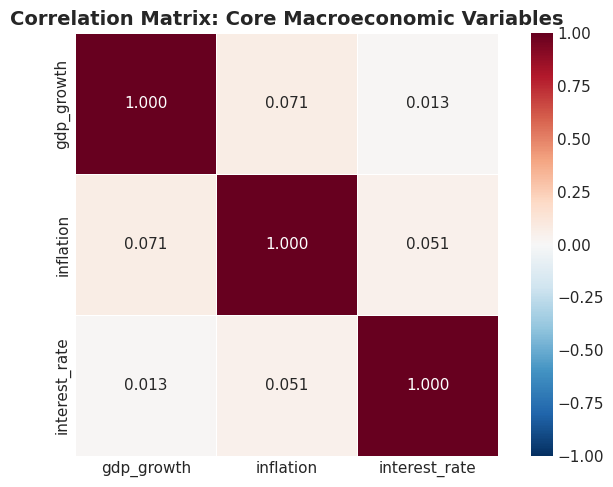


Key observation: Correlation captures static co-movement, but NOT dynamic effects.
A positive correlation between inflation and interest_rate does not tell us
whether inflation CAUSES rate hikes or rate hikes CAUSE inflation.
VAR models capture these dynamic, lagged relationships.


In [3]:
# Focus on the three core endogenous variables
core_vars = ['gdp_growth', 'inflation', 'interest_rate']

# Compute correlation matrix across the full panel
corr_matrix = df[core_vars].corr()

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    vmin=-1, vmax=1,
    linewidths=0.5,
    square=True,
    ax=ax
)
ax.set_title('Correlation Matrix: Core Macroeconomic Variables', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig(FIGURES_DIR / '01_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('\nKey observation: Correlation captures static co-movement, but NOT dynamic effects.')
print('A positive correlation between inflation and interest_rate does not tell us')
print('whether inflation CAUSES rate hikes or rate hikes CAUSE inflation.')
print('VAR models capture these dynamic, lagged relationships.')

### Why Panel VAR?

Traditional (time-series) VAR uses data from a single country. **Panel VAR** extends this to multiple entities (countries, firms, regions), offering several advantages:

| Feature | Time-Series VAR | Panel VAR |
|---|---|---|
| Sample size | T observations | N x T observations |
| Entity heterogeneity | Not modeled | Controlled via fixed effects |
| Cross-sectional variation | None | Exploits variation across entities |
| Parameter efficiency | Limited by T | Pooled estimation, more precise |

In our dataset, we have **30 countries x 40 quarters = 1,200 observations**, providing much more statistical power than any single country alone.

---

## 2. VAR(p) Specification

### Mathematical Formulation

A **VAR(p)** model with K endogenous variables specifies:

$$
\mathbf{Y}_t = \mathbf{A}_1 \mathbf{Y}_{t-1} + \mathbf{A}_2 \mathbf{Y}_{t-2} + \cdots + \mathbf{A}_p \mathbf{Y}_{t-p} + \boldsymbol{\varepsilon}_t
$$

where:
- $\mathbf{Y}_t = (y_{1t}, y_{2t}, \ldots, y_{Kt})'$ is a $K \times 1$ vector of endogenous variables
- $\mathbf{A}_l$ is a $K \times K$ coefficient matrix for lag $l$
- $\boldsymbol{\varepsilon}_t \sim (\mathbf{0}, \boldsymbol{\Sigma})$ is a $K \times 1$ white-noise error vector
- $p$ is the lag order

### Coefficient Interpretation

The element $A_1[i, j]$ captures the **effect of variable $j$ at time $t-1$ on variable $i$ at time $t$**, holding all other lagged values constant.

For our 3-variable system (gdp_growth, inflation, interest_rate):

$$
\begin{pmatrix} \text{gdp}_{t} \\ \text{inf}_{t} \\ \text{rate}_{t} \end{pmatrix}
= \underbrace{\begin{pmatrix} a_{11} & a_{12} & a_{13} \\ a_{21} & a_{22} & a_{23} \\ a_{31} & a_{32} & a_{33} \end{pmatrix}}_{\mathbf{A}_1}
\begin{pmatrix} \text{gdp}_{t-1} \\ \text{inf}_{t-1} \\ \text{rate}_{t-1} \end{pmatrix}
+ \cdots + \boldsymbol{\varepsilon}_t
$$

For example:
- $a_{11}$: persistence of GDP growth
- $a_{12}$: effect of past inflation on current GDP growth
- $a_{31}$: effect of past GDP growth on current interest rates (policy response)

### Panel VAR Extension

The Panel VAR adds entity-specific fixed effects to control for unobserved heterogeneity:

$$
\mathbf{Y}_{it} = \boldsymbol{\alpha}_i + \mathbf{A}_1 \mathbf{Y}_{i,t-1} + \cdots + \mathbf{A}_p \mathbf{Y}_{i,t-p} + \boldsymbol{\varepsilon}_{it}
$$

where $\boldsymbol{\alpha}_i$ is a $K \times 1$ vector of fixed effects for entity $i$.

### Simulation: What Does a VAR Process Look Like?

Before working with real data, let us simulate a simple Panel VAR(1) to build intuition for how the coefficient matrix shapes the dynamics of the system.

In [4]:
# Define a simple 3-variable VAR(1) process
# Coefficients chosen to be economically plausible:
#   - GDP is persistent (a11 = 0.4) and negatively affected by interest rate (a13 = -0.15)
#   - Inflation is persistent (a22 = 0.5) and slightly responds to GDP (a21 = 0.10)
#   - Interest rate responds to inflation (a32 = 0.20) -- Taylor rule logic

A1_sim = np.array([
    [ 0.40,  0.05, -0.15],   # GDP growth equation
    [ 0.10,  0.50,  0.05],   # Inflation equation
    [ 0.05,  0.20,  0.30],   # Interest rate equation
])

# Residual covariance matrix (mild cross-equation correlation)
Sigma_sim = np.array([
    [1.0, 0.2, 0.1],
    [0.2, 0.8, 0.15],
    [0.1, 0.15, 0.6],
])

# Check stability of the DGP
stability_check = check_stability([A1_sim])
print(f'DGP Stability Check:')
print(f'  Stable: {stability_check["is_stable"]}')
print(f'  Max eigenvalue modulus: {stability_check["max_modulus"]:.4f}')
print(f'  Eigenvalues: {stability_check["eigenvalues"]}')

DGP Stability Check:
  Stable: True
  Max eigenvalue modulus: 0.4858
  Eigenvalues: [0.48265836+0.05474681j 0.48265836-0.05474681j 0.23468328+0.j        ]


In [5]:
# Simulate a panel VAR with 5 entities and 100 time periods
sim_panel = simulate_panel_var(
    A_matrices=[A1_sim],
    Sigma=Sigma_sim,
    n_entities=5,
    n_periods=100,
    fixed_effects_std=0.5,
    seed=42
)

print(f'Simulated panel shape: {sim_panel.shape}')
print(f'Columns: {list(sim_panel.columns)}')
sim_panel.head(10)

Simulated panel shape: (500, 5)
Columns: ['entity', 'time', 'y_0', 'y_1', 'y_2']


,entity,time,y_0,y_1,y_2
0,0,0,0.287332,0.174304,1.338696
1,0,1,0.865358,-0.364442,1.218675
2,0,2,1.870640,-0.909949,1.322443
3,0,3,0.716456,-0.861621,0.427301
4,0,4,-0.326745,-1.291432,-0.961060
5,0,5,-1.297958,-3.663578,-1.480101
6,0,6,0.533278,-2.404302,-0.602301
7,0,7,1.480346,-1.393154,1.205394
8,0,8,-0.392178,-0.538633,0.084382
9,0,9,-0.974529,-1.469566,0.788721


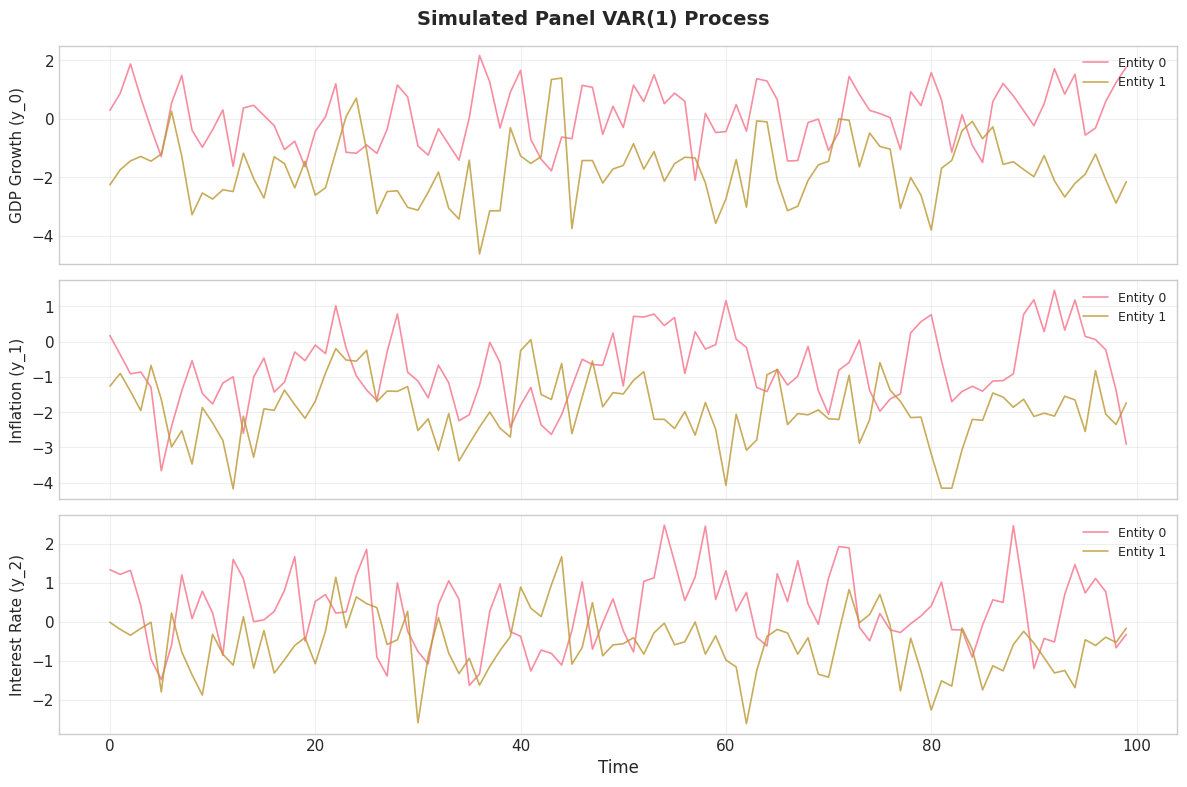

Notice how:
  - Each entity has a different level (fixed effects)
  - The dynamic patterns are similar (common A matrices)
  - Variables co-move due to cross-equation dependencies


In [6]:
# Visualize simulated data for two entities
var_labels = ['GDP Growth (y_0)', 'Inflation (y_1)', 'Interest Rate (y_2)']

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for entity_id in [0, 1]:
    entity_data = sim_panel[sim_panel['entity'] == entity_id]
    for k, (col, label) in enumerate(zip(['y_0', 'y_1', 'y_2'], var_labels)):
        axes[k].plot(
            entity_data['time'], entity_data[col],
            linewidth=1.2, alpha=0.8,
            label=f'Entity {entity_id}'
        )
        axes[k].set_ylabel(label, fontsize=11)
        axes[k].legend(loc='upper right', fontsize=9)
        axes[k].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time', fontsize=12)
fig.suptitle('Simulated Panel VAR(1) Process', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig(FIGURES_DIR / '01_simulated_panel_var.png', dpi=150, bbox_inches='tight')
plt.show()

print('Notice how:')
print('  - Each entity has a different level (fixed effects)')
print('  - The dynamic patterns are similar (common A matrices)')
print('  - Variables co-move due to cross-equation dependencies')

---

## 3. Data Preparation

Now let us work with the actual macroeconomic panel dataset. This section covers loading, inspecting, and preparing the data for Panel VAR estimation.

In [7]:
# Load the macro panel data
df = pd.read_csv('../data/macro_panel.csv')

# Convert quarter strings to pandas PeriodIndex (required by PanelVARData)
df['quarter'] = pd.PeriodIndex(df['quarter'], freq='Q')

print('=== Dataset Overview ===')
print(f'Shape: {df.shape} ({df.shape[0]} rows, {df.shape[1]} columns)')
print(f'\nCountries (N): {df["country"].nunique()}')
print(f'Quarters (T): {df["quarter"].nunique()}')
print(f'\nCountry list:')
print(sorted(df['country'].unique()))

=== Dataset Overview ===
Shape: (1200, 7) (1200 rows, 7 columns)

Countries (N): 30
Quarters (T): 40

Country list:
['AUS', 'AUT', 'BEL', 'BRA', 'CAN', 'CHE', 'CHN', 'CZE', 'DEU', 'DNK', 'ESP', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'MEX', 'NLD', 'NOR', 'POL', 'PRT', 'SWE', 'TUR', 'USA', 'ZAF']


In [8]:
# Descriptive statistics
print('=== Descriptive Statistics ===')
print(df[core_vars + ['unemployment', 'exchange_rate']].describe().round(3).to_string())

print(f'\n=== Missing Values ===')
print(df.isnull().sum().to_string())

=== Descriptive Statistics ===
       gdp_growth  inflation  interest_rate  unemployment  exchange_rate
count    1200.000   1200.000       1200.000      1200.000       1200.000
mean        1.796      3.121          4.233         7.163         99.268
std         1.606      1.872          2.009         2.324          9.208
min        -3.402     -2.042          0.000         0.000         76.653
25%         0.721      1.883          2.845         5.513         92.276
50%         1.793      3.122          4.375         7.024         99.300
75%         2.850      4.352          5.591         8.790        104.573
max         7.209     10.157         11.155        14.371        123.294

=== Missing Values ===
country          0
quarter          0
gdp_growth       0
inflation        0
interest_rate    0
unemployment     0
exchange_rate    0


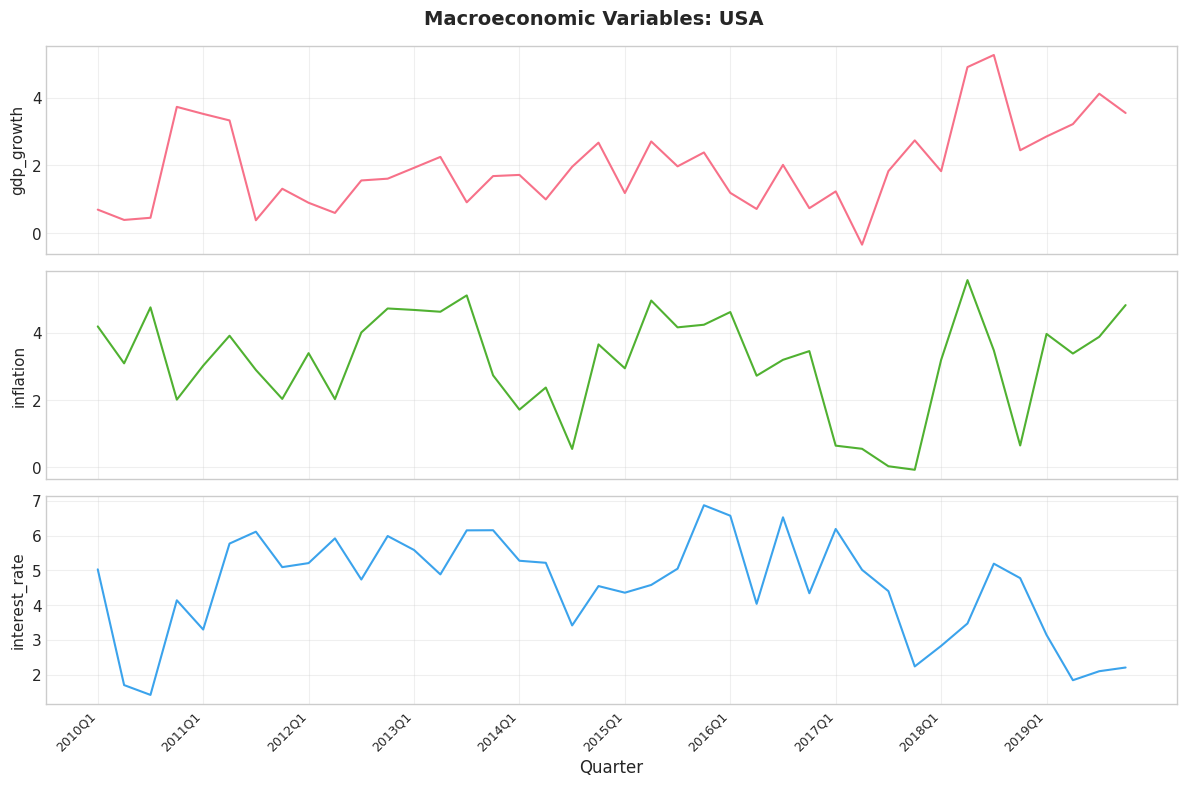

In [9]:
# Time series plot for one sample country
sample_country = df['country'].unique()[0]
country_data = df[df['country'] == sample_country].copy()

fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

for k, var in enumerate(core_vars):
    axes[k].plot(range(len(country_data)), country_data[var].values,
                 linewidth=1.5, color=sns.color_palette('husl', 3)[k])
    axes[k].set_ylabel(var, fontsize=11)
    axes[k].grid(True, alpha=0.3)

# Label x-axis with quarter strings (show every 4th quarter for readability)
tick_positions = range(0, len(country_data), 4)
tick_labels = country_data['quarter'].values[::4]
axes[-1].set_xticks(list(tick_positions))
axes[-1].set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=9)
axes[-1].set_xlabel('Quarter', fontsize=12)

fig.suptitle(f'Macroeconomic Variables: {sample_country}', fontsize=14, fontweight='bold')
fig.tight_layout()
fig.savefig(FIGURES_DIR / '01_time_series_sample_country.png', dpi=150, bbox_inches='tight')
plt.show()

### Creating the PanelVARData Object

PanelBox provides the `PanelVARData` class that handles:
- Automatic lag construction (within each entity, avoiding cross-entity contamination)
- Balance checking
- Temporal gap detection
- Consistent missing-value handling across all equations

In [10]:
# Create PanelVARData object
data = PanelVARData(
    df,
    endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
    entity_col='country',
    time_col='quarter',
    lags=2
)

# Inspect key properties
print('=== PanelVARData Properties ===')
print(f'K (endogenous variables): {data.K}')
print(f'p (lags):                 {data.p}')
print(f'N (entities):             {data.N}')
print(f'n_obs (total obs):        {data.n_obs}')
print(f'is_balanced:              {data.is_balanced}')

=== PanelVARData Properties ===
K (endogenous variables): 3
p (lags):                 2
N (entities):             30
n_obs (total obs):        1140
is_balanced:              True


Note that `n_obs` is less than 1,200 because constructing 2 lags consumes the first 2 time periods for each entity. With 30 countries and 2 lags removed from each, we lose $30 \times 2 = 60$ observations.

---

## 4. OLS Estimation

### Estimation Strategy

Panel VAR estimation proceeds in two steps:

1. **Within transformation**: Remove entity fixed effects by subtracting entity means from each variable (demeaning). This eliminates $\boldsymbol{\alpha}_i$ from the model.

2. **Equation-by-equation OLS**: Estimate each equation of the VAR system separately using OLS on the demeaned data. Each equation has the same regressors (lagged values of all endogenous variables), so equation-by-equation OLS is equivalent to SUR (Seemingly Unrelated Regressions) in this case.

Standard errors can be computed using different covariance estimators:
- `'clustered'`: Clustered by entity (robust to within-entity correlation)
- `'hc1'`: Heteroskedasticity-robust (White HC1)
- `'nonrobust'`: Classical OLS standard errors

In [11]:
# Fit the Panel VAR(2) model
model = PanelVAR(data)
results = model.fit(method='ols', cov_type='clustered')

# Print the full summary
print(results.summary())

Panel VAR Results
Method: OLS
Number of entities (N): 30
Number of observations: 1140
Lags (p): 2
Number of equations (K): 3
Covariance type: clustered

System Information Criteria:
  AIC:  1.097705
  BIC:  1.190524
  HQIC: 1.132758
  Log-Likelihood: -5457.46

Stability:
  Stable: Yes
  Max eigenvalue modulus: 0.691437

---------------------------------------------------------------------------
Equation 1: gdp_growth
---------------------------------------------------------------------------
                      coef   std err         t     P>|t|    [0.025    0.975]
L1.gdp_growth     0.345492  0.035717  9.672914  0.000000  0.275485  0.415498
L1.inflation      0.004928  0.020488  0.240524  0.809968 -0.035228  0.045084
L1.interest_rate -0.166091  0.036417 -4.560784  0.000006 -0.237469 -0.094713
L2.gdp_growth     0.060162  0.033816  1.779105  0.075490 -0.006117  0.126440
L2.inflation      0.042673  0.034773  1.227204  0.220001 -0.025481  0.110828
L2.interest_rate -0.076138  0.030784 -2.4

In [12]:
# Extract and display coefficient matrices
print('=== Coefficient Matrix A_1 (Lag 1) ===')
A1_df = results.coef_matrix(lag=1)
print(A1_df.round(4).to_string())

print(f'\n=== Coefficient Matrix A_2 (Lag 2) ===')
A2_df = results.coef_matrix(lag=2)
print(A2_df.round(4).to_string())

=== Coefficient Matrix A_1 (Lag 1) ===
               gdp_growth  inflation  interest_rate
gdp_growth         0.3455     0.0049        -0.1661
inflation          0.0760     0.4442        -0.0486
interest_rate      0.0153     0.1935         0.5597

=== Coefficient Matrix A_2 (Lag 2) ===
               gdp_growth  inflation  interest_rate
gdp_growth         0.0602     0.0427        -0.0761
inflation          0.0486     0.0658        -0.0157
interest_rate      0.1053     0.0267         0.0516


In [13]:
# Residual covariance matrix (Sigma)
print('=== Residual Covariance Matrix (Sigma) ===')
Sigma_df = pd.DataFrame(
    results.Sigma,
    index=results.endog_names,
    columns=results.endog_names
)
print(Sigma_df.round(6).to_string())

# Also show as correlation matrix
D_inv = np.diag(1.0 / np.sqrt(np.diag(results.Sigma)))
resid_corr = D_inv @ results.Sigma @ D_inv
resid_corr_df = pd.DataFrame(
    resid_corr,
    index=results.endog_names,
    columns=results.endog_names
)
print(f'\n=== Residual Correlation Matrix ===')
print(resid_corr_df.round(4).to_string())

=== Residual Covariance Matrix (Sigma) ===
               gdp_growth  inflation  interest_rate
gdp_growth       1.470802   0.249693       0.056114
inflation        0.249693   1.811628       0.029450
interest_rate    0.056114   0.029450       1.112526

=== Residual Correlation Matrix ===
               gdp_growth  inflation  interest_rate
gdp_growth         1.0000     0.1530         0.0439
inflation          0.1530     1.0000         0.0207
interest_rate      0.0439     0.0207         1.0000


### Economic Interpretation of Key Coefficients

Let us highlight the most economically meaningful coefficients from the A_1 matrix:

- **Diagonal elements** (persistence): How much each variable depends on its own past value. Values close to 1 indicate high persistence.

- **Off-diagonal elements** (spillovers): How past values of one variable affect the current value of another.

Key relationships to look for:
- `interest_rate <- inflation` (positive = monetary policy tightening when inflation rises)
- `gdp_growth <- interest_rate` (negative = contractionary monetary policy reduces growth)
- `inflation <- gdp_growth` (positive = demand-pull inflation)

In [14]:
# Highlight key economic relationships in A_1
print('=== Key Economic Relationships (A_1 coefficients) ===')
print()

A1 = results.coef_matrix(lag=1)

relationships = [
    ('gdp_growth', 'gdp_growth', 'GDP persistence'),
    ('inflation', 'inflation', 'Inflation persistence'),
    ('interest_rate', 'interest_rate', 'Interest rate persistence'),
    ('gdp_growth', 'interest_rate', 'Monetary policy -> GDP (expected negative)'),
    ('inflation', 'gdp_growth', 'GDP -> Inflation (demand-pull)'),
    ('interest_rate', 'inflation', 'Inflation -> Interest rate (Taylor rule)'),
]

for row_var, col_var, description in relationships:
    coef = A1.loc[row_var, col_var]
    sign = '+' if coef > 0 else '-'
    print(f'  {description}')
    print(f'    A_1[{row_var}, {col_var}] = {coef:+.4f}')
    print()

# Save coefficient tables to CSV
A1_df.to_csv(TABLES_DIR / '01_coefficient_matrix_A1.csv')
A2_df.to_csv(TABLES_DIR / '01_coefficient_matrix_A2.csv')
Sigma_df.to_csv(TABLES_DIR / '01_residual_covariance.csv')
print('Coefficient tables saved to ../outputs/tables/')

=== Key Economic Relationships (A_1 coefficients) ===

  GDP persistence
    A_1[gdp_growth, gdp_growth] = +0.3455

  Inflation persistence
    A_1[inflation, inflation] = +0.4442

  Interest rate persistence
    A_1[interest_rate, interest_rate] = +0.5597

  Monetary policy -> GDP (expected negative)
    A_1[gdp_growth, interest_rate] = -0.1661

  GDP -> Inflation (demand-pull)
    A_1[inflation, gdp_growth] = +0.0760

  Inflation -> Interest rate (Taylor rule)
    A_1[interest_rate, inflation] = +0.1935

Coefficient tables saved to ../outputs/tables/


---

## 5. Lag Order Selection

### Information Criteria Theory

Choosing the right number of lags $p$ is critical. Too few lags can cause omitted variable bias; too many lags waste degrees of freedom and introduce noise.

**Information criteria** balance model fit (log-likelihood) against model complexity (number of parameters):

| Criterion | Formula | Tendency |
|---|---|---|
| AIC | $\ln|\hat{\Sigma}| + \frac{2 m}{n}$ | Tends to select more lags |
| BIC | $\ln|\hat{\Sigma}| + \frac{m \ln(n)}{n}$ | Tends to select fewer lags (consistent) |
| HQIC | $\ln|\hat{\Sigma}| + \frac{2 m \ln(\ln(n))}{n}$ | Between AIC and BIC |

where $m = K^2 p$ is the total number of estimated parameters and $n$ is the number of observations.

**Rule of thumb:** If AIC and BIC disagree, prefer BIC for consistent estimation, but verify robustness.

In [15]:
# Lag order selection
# Note: we need to re-create data with max_lags capacity
# The select_lag_order method handles this internally
data_for_selection = PanelVARData(
    df,
    endog_vars=['gdp_growth', 'inflation', 'interest_rate'],
    entity_col='country',
    time_col='quarter',
    lags=8  # set to max_lags so internal comparison is valid
)

model_selection = PanelVAR(data_for_selection)
lag_results = model_selection.select_lag_order(max_lags=8)

# Print the summary
print(lag_results.summary())

Lag Order Selection

        lags           AIC           BIC          HQIC          MBIC
--------------------------------------------------------------------
           1      1.126029     1.177975*      1.145621     1.211765*
           2     1.097705*      1.190524     1.132758*      1.277742
           3      1.114247      1.249710      1.165471      1.392392
           4      1.102747      1.282751      1.170905      1.483071
           5      1.112336      1.338921      1.198250      1.599200
           6      1.128219      1.403583      1.232776      1.726308
           7      1.112520      1.439033      1.236678      1.826872
           8      1.139761      1.519990      1.284561      1.975809

Selected lags:
  AIC: 2
  BIC: 1
  HQIC: 2
  MBIC: 1



In [16]:
# Display the criteria DataFrame
print('=== Information Criteria Table ===')
print(lag_results.criteria_df.round(6).to_string(index=False))

=== Information Criteria Table ===
 lags      AIC      BIC     HQIC     MBIC
    1 1.126029 1.177975 1.145621 1.211765
    2 1.097705 1.190524 1.132758 1.277742
    3 1.114247 1.249710 1.165471 1.392392
    4 1.102747 1.282751 1.170905 1.483071
    5 1.112336 1.338921 1.198250 1.599200
    6 1.128219 1.403583 1.232776 1.726308
    7 1.112520 1.439033 1.236678 1.826872
    8 1.139761 1.519990 1.284561 1.975809


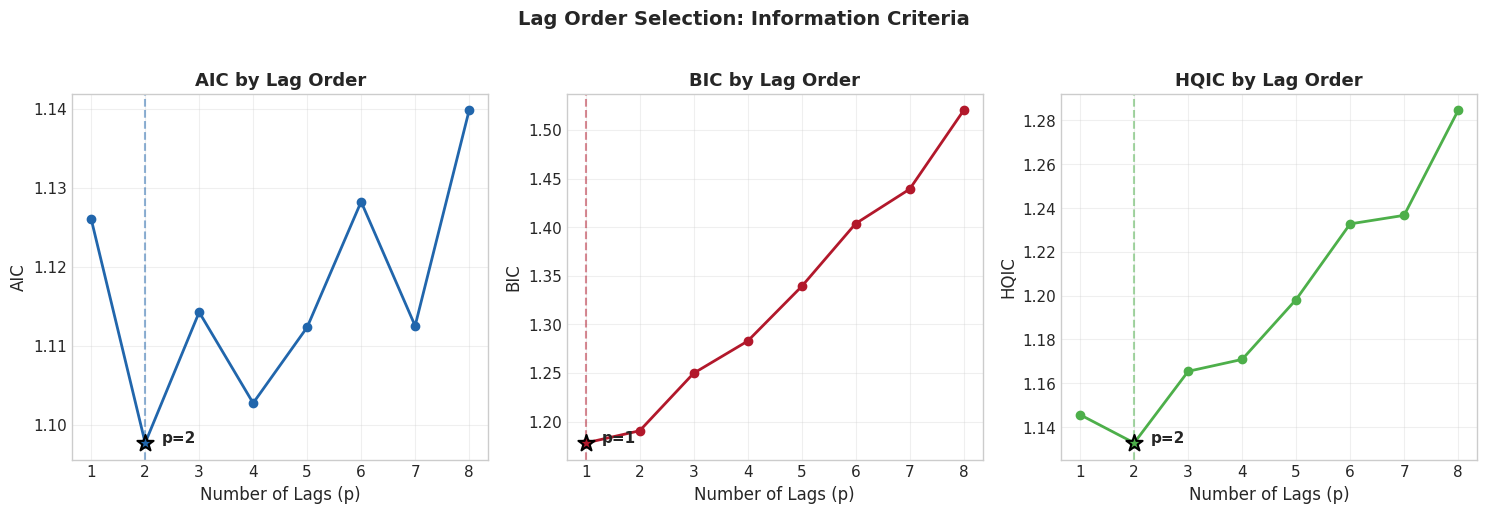

In [17]:
# Plot information criteria across lag orders
criteria_df = lag_results.criteria_df

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

criteria_names = ['AIC', 'BIC', 'HQIC']
colors = ['#2166ac', '#b2182b', '#4daf4a']

for ax, criterion, color in zip(axes, criteria_names, colors):
    if criterion in criteria_df.columns:
        ax.plot(
            criteria_df['lags'], criteria_df[criterion],
            'o-', color=color, linewidth=2, markersize=6, label=criterion
        )
        # Mark the selected lag
        if criterion in lag_results.selected:
            best_lag = lag_results.selected[criterion]
            best_val = criteria_df.loc[criteria_df['lags'] == best_lag, criterion].values[0]
            ax.axvline(x=best_lag, color=color, linestyle='--', alpha=0.5)
            ax.scatter([best_lag], [best_val], color=color, s=150, zorder=5,
                       edgecolors='black', linewidth=1.5, marker='*')
            ax.annotate(
                f'p={best_lag}',
                xy=(best_lag, best_val),
                xytext=(best_lag + 0.3, best_val),
                fontsize=11, fontweight='bold'
            )
    ax.set_xlabel('Number of Lags (p)', fontsize=12)
    ax.set_ylabel(criterion, fontsize=12)
    ax.set_title(f'{criterion} by Lag Order', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(criteria_df['lags'].values)

fig.suptitle('Lag Order Selection: Information Criteria', fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig(FIGURES_DIR / '01_lag_order_selection.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Report selected lag orders
print('=== Selected Lag Orders ===')
for criterion, lag in lag_results.selected.items():
    print(f'  {criterion}: p = {lag}')

# Save criteria table
lag_results.criteria_df.to_csv(TABLES_DIR / '01_lag_selection_criteria.csv', index=False)
print(f'\nCriteria table saved to ../outputs/tables/01_lag_selection_criteria.csv')

=== Selected Lag Orders ===
  AIC: p = 2
  BIC: p = 1
  HQIC: p = 2
  MBIC: p = 1

Criteria table saved to ../outputs/tables/01_lag_selection_criteria.csv


---

## 6. Stability Analysis

### Why Stability Matters

A VAR system is **stable** (stationary) if and only if **all eigenvalues of the companion matrix** have modulus strictly less than 1 (lie inside the unit circle in the complex plane).

Stability is essential because:
- **Impulse response functions** converge to zero only if the system is stable
- **Forecasts** do not explode only if the system is stable
- **Variance decompositions** are well-defined only under stability

### Companion Matrix

For a VAR(p) with K variables, the companion matrix $\mathbf{F}$ is $Kp \times Kp$:

$$
\mathbf{F} = \begin{pmatrix}
\mathbf{A}_1 & \mathbf{A}_2 & \cdots & \mathbf{A}_p \\
\mathbf{I}_K & \mathbf{0} & \cdots & \mathbf{0} \\
\mathbf{0} & \mathbf{I}_K & \cdots & \mathbf{0} \\
\vdots & & \ddots & \vdots \\
\mathbf{0} & \mathbf{0} & \cdots & \mathbf{0}
\end{pmatrix}
$$

This transforms the VAR(p) into a first-order system $\mathbf{Z}_t = \mathbf{F} \mathbf{Z}_{t-1} + \mathbf{u}_t$, where the eigenvalues of $\mathbf{F}$ determine the system dynamics.

In [19]:
# Check stability
print('=== Stability Analysis ===')
print(f'Is stable: {results.is_stable()}')
print(f'Max eigenvalue modulus: {results.max_eigenvalue_modulus:.6f}')
print(f'Stability margin (1 - max|lambda|): {1 - results.max_eigenvalue_modulus:.6f}')

# Show all eigenvalues
eigenvalues = results.eigenvalues
print(f'\nEigenvalues of companion matrix ({len(eigenvalues)} total):')
for i, ev in enumerate(eigenvalues):
    modulus = np.abs(ev)
    print(f'  lambda_{i+1} = {ev.real:+.4f} {ev.imag:+.4f}i   |lambda| = {modulus:.4f}')

=== Stability Analysis ===
Is stable: True
Max eigenvalue modulus: 0.691437
Stability margin (1 - max|lambda|): 0.308563

Eigenvalues of companion matrix (6 total):
  lambda_1 = +0.6559 +0.2190i   |lambda| = 0.6914
  lambda_2 = +0.6559 -0.2190i   |lambda| = 0.6914
  lambda_3 = +0.4050 +0.0000i   |lambda| = 0.4050
  lambda_4 = -0.1266 +0.0757i   |lambda| = 0.1475
  lambda_5 = -0.1266 -0.0757i   |lambda| = 0.1475
  lambda_6 = -0.1141 +0.0000i   |lambda| = 0.1141


In [20]:
# Companion matrix
F = results.companion_matrix()
print(f'Companion matrix shape: {F.shape} (Kp x Kp = {results.K * results.p} x {results.K * results.p})')
print(f'\nCompanion matrix F:')
print(pd.DataFrame(F).round(4).to_string())

Companion matrix shape: (6, 6) (Kp x Kp = 6 x 6)

Companion matrix F:
        0       1       2       3       4       5
0  0.3455  0.0049 -0.1661  0.0602  0.0427 -0.0761
1  0.0760  0.4442 -0.0486  0.0486  0.0658 -0.0157
2  0.0153  0.1935  0.5597  0.1053  0.0267  0.0516
3  1.0000  0.0000  0.0000  0.0000  0.0000  0.0000
4  0.0000  1.0000  0.0000  0.0000  0.0000  0.0000
5  0.0000  0.0000  1.0000  0.0000  0.0000  0.0000


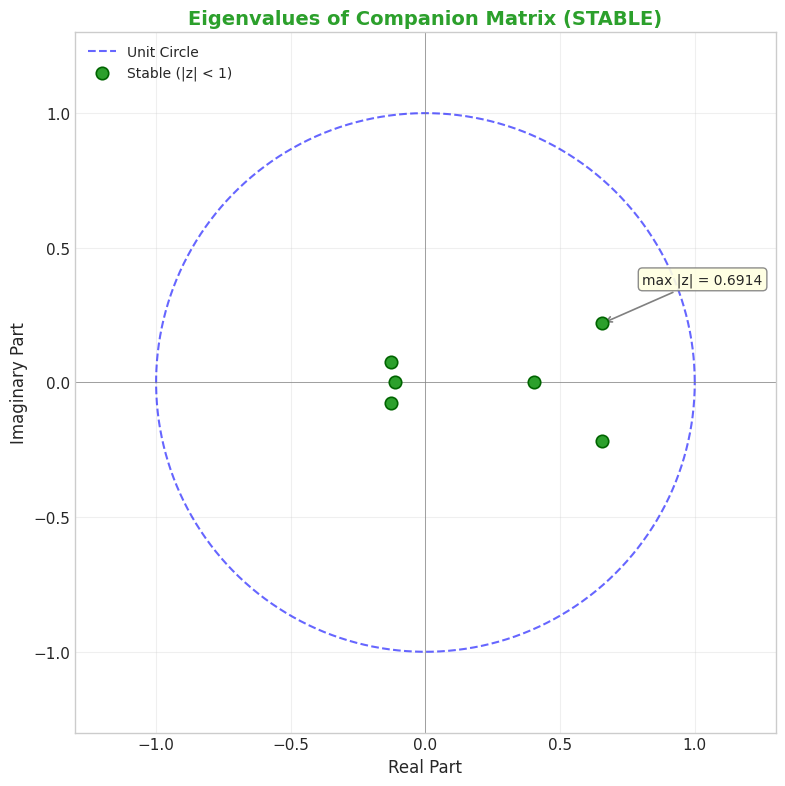


Interpretation: All eigenvalues lie inside the unit circle.
The VAR system is STABLE: impulse responses will converge to zero
and forecasts will not explode.


In [21]:
# Plot eigenvalues on the unit circle using the utility function
fig = plot_stability_diagram(
    results,
    save_path=str(FIGURES_DIR / '01_stability_unit_circle.png')
)
plt.show()

if results.is_stable():
    print('\nInterpretation: All eigenvalues lie inside the unit circle.')
    print('The VAR system is STABLE: impulse responses will converge to zero')
    print('and forecasts will not explode.')
else:
    print('\nWARNING: The system is UNSTABLE. Some eigenvalues have modulus >= 1.')
    print('IRFs may diverge and forecasts may explode. Consider re-specifying the model.')

---

## 7. Coefficient Visualization

Heatmaps provide an intuitive way to visualize the structure of the VAR coefficient matrices. The color intensity indicates the **magnitude and sign** of each coefficient:

- **Blue** = positive effect (variable $j$ at $t-l$ increases variable $i$ at $t$)
- **Red** = negative effect
- **Diagonal elements** = persistence (own-lag effects)
- **Off-diagonal elements** = cross-variable spillovers

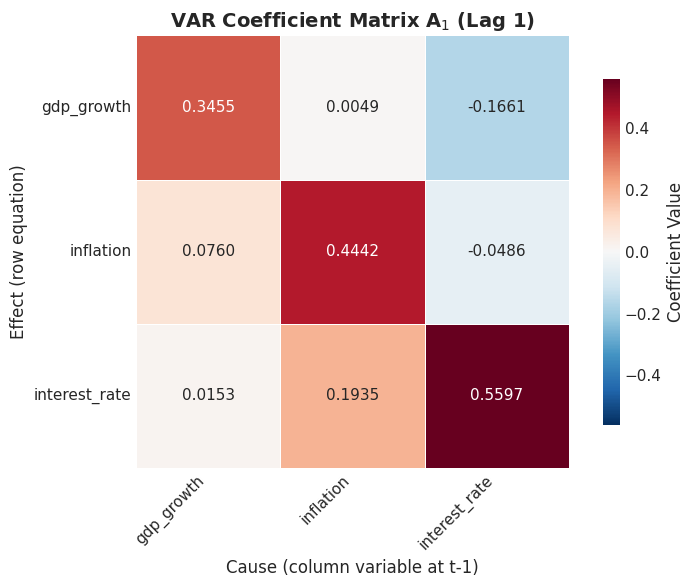

In [22]:
# Heatmap of A_1 using the utility function
fig = plot_coefficient_heatmap(
    results,
    lag=1,
    save_path=str(FIGURES_DIR / '01_coefficient_heatmap_A1.png')
)
plt.show()

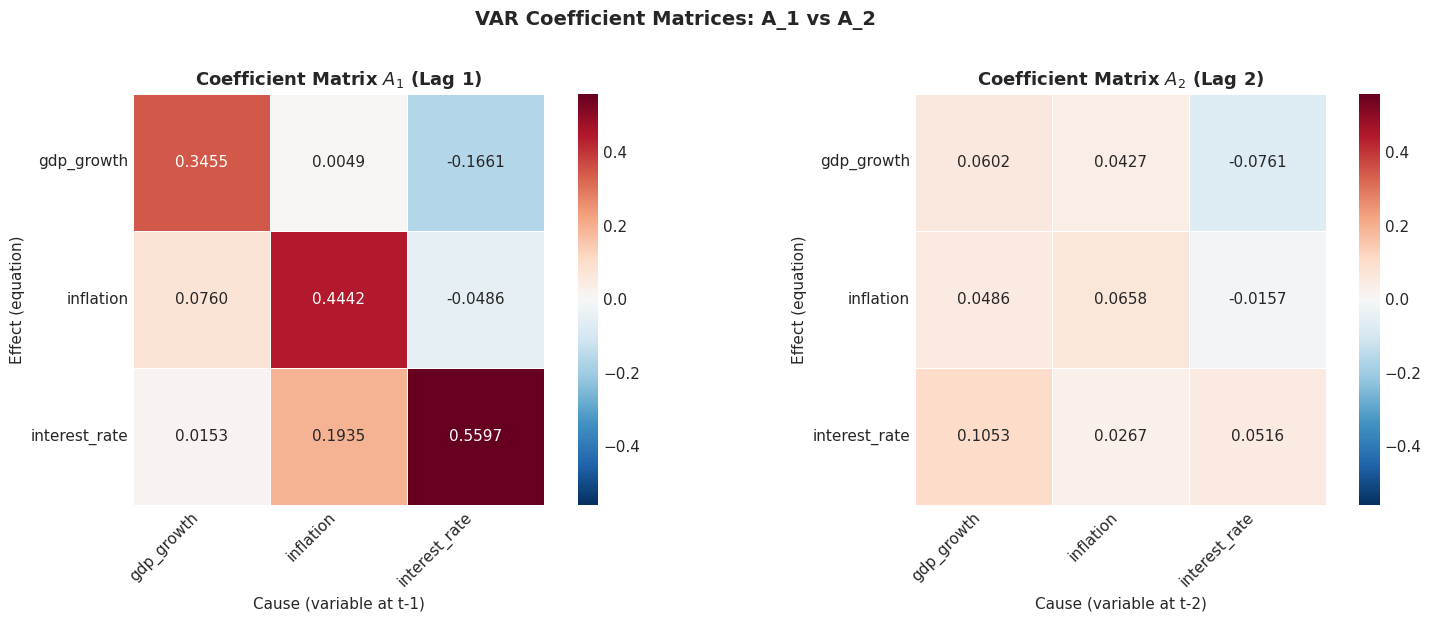

Interpretation:
  - Diagonal = persistence (how much a variable depends on its own lag)
  - Off-diagonal = spillovers (how one variable affects another)
  - A_1 typically shows stronger effects than A_2 (more recent lag matters more)


In [23]:
# Side-by-side comparison of A_1 and A_2
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for lag_num, ax in zip([1, 2], axes):
    A_l = results.A_matrices[lag_num - 1]
    coef_df = pd.DataFrame(A_l, index=results.endog_names, columns=results.endog_names)
    
    vmax = max(np.max(np.abs(results.A_matrices[0])), np.max(np.abs(results.A_matrices[1])))
    if vmax < 1e-10:
        vmax = 1.0
    
    sns.heatmap(
        coef_df,
        annot=True,
        fmt='.4f',
        cmap='RdBu_r',
        center=0,
        vmin=-vmax,
        vmax=vmax,
        linewidths=0.5,
        linecolor='white',
        square=True,
        ax=ax
    )
    ax.set_title(f'Coefficient Matrix $A_{lag_num}$ (Lag {lag_num})',
                 fontsize=13, fontweight='bold')
    ax.set_xlabel(f'Cause (variable at t-{lag_num})', fontsize=11)
    ax.set_ylabel('Effect (equation)', fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

fig.suptitle('VAR Coefficient Matrices: A_1 vs A_2', fontsize=14, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig(FIGURES_DIR / '01_coefficient_heatmaps_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print('Interpretation:')
print('  - Diagonal = persistence (how much a variable depends on its own lag)')
print('  - Off-diagonal = spillovers (how one variable affects another)')
print('  - A_1 typically shows stronger effects than A_2 (more recent lag matters more)')

---

## 8. Summary

### Key Takeaways

1. **VAR models** capture dynamic interdependencies among multiple variables -- something that single-equation regressions cannot do. They model each variable as a function of its own past values and the past values of all other variables in the system.

2. **Panel VAR** extends the VAR framework to panel data (multiple entities observed over time), providing more statistical power and controlling for unobserved entity heterogeneity through fixed effects.

3. **Coefficient matrices** ($A_1, A_2, \ldots$) encode the dynamic structure: diagonal elements capture persistence, off-diagonal elements capture cross-variable spillovers.

4. **Lag order selection** using information criteria (AIC, BIC, HQIC) is essential to avoid under- or over-parameterization. BIC provides consistent lag selection; AIC tends to select more lags.

5. **Stability analysis** via the eigenvalues of the companion matrix is a necessary check before computing IRFs or forecasts. All eigenvalues must lie inside the unit circle.

### What Comes Next

| Notebook | Topic |
|---|---|
| **02** | Impulse Response Functions (IRF) -- tracing the effect of shocks over time |
| **03** | Forecast Error Variance Decomposition (FEVD) -- quantifying how much of each variable's variance is explained by shocks to other variables |
| **04** | Granger Causality and Forecasting -- testing predictive relationships and generating out-of-sample forecasts |

### References

- Sims, C. A. (1980). Macroeconomics and reality. *Econometrica*, 48(1), 1-48.
- Holtz-Eakin, D., Newey, W., & Rosen, H. S. (1988). Estimating vector autoregressions with panel data. *Econometrica*, 56(6), 1371-1395.
- Love, I., & Zicchino, L. (2006). Financial development and dynamic investment behavior. *The Quarterly Review of Economics and Finance*, 46(2), 190-210.
- Lutkepohl, H. (2005). *New Introduction to Multiple Time Series Analysis*. Springer.

---

## 9. Exercises

### Exercise 1: Different Lag Orders (Easy)

Estimate the Panel VAR model with lag orders p=1, p=2, and p=3. Compare the information criteria (AIC, BIC) across these specifications. Which lag order does each criterion prefer?

**Expected output:** A comparison table showing AIC, BIC, HQIC, and log-likelihood for each lag order.

**Hint:** Create a new `PanelVARData` object for each lag order, fit the model, and collect `results.aic`, `results.bic`, `results.hqic`, and `results.loglik`.

In [24]:
# Exercise 1: Compare lag orders p=1, 2, 3
# YOUR CODE HERE

### Exercise 2: Different Covariance Types (Medium)

Re-estimate the VAR(2) model using three different covariance estimators: `'nonrobust'`, `'hc1'`, and `'clustered'`. Compare the standard errors and t-statistics for the key coefficients. Which estimator produces the most conservative (largest) standard errors?

**Expected output:** A table with coefficients and standard errors for each covariance type, showing how inference changes.

**Hint:** Use the same `PanelVARData` object but call `model.fit()` with different `cov_type` arguments. Use `results.coef_matrix(lag=1)` and `results.equation_summary(k)` to extract results.

In [25]:
# Exercise 2: Compare covariance types
# YOUR CODE HERE

### Exercise 3: Adding an Exogenous Variable (Medium)

Add a crisis dummy variable to the model. Create a binary variable that equals 1 for quarters `2011-Q3` through `2012-Q4` (European sovereign debt crisis) and 0 otherwise. Re-estimate the model with this exogenous variable and compare the coefficient matrices to the baseline.

**Expected output:** New coefficient matrices and a discussion of whether the dynamic relationships change when controlling for crisis periods.

**Hint:** Create the dummy column using Period comparison, then pass it via the `exog_vars` parameter of `PanelVARData`:
```python
df['crisis'] = ((df['quarter'] >= pd.Period('2011Q3', freq='Q')) &
                (df['quarter'] <= pd.Period('2012Q4', freq='Q'))).astype(int)
```

In [26]:
# Exercise 3: Add exogenous crisis dummy
# YOUR CODE HERE

### Exercise 4: Subset Analysis -- Advanced vs. Emerging Economies (Hard)

Split the panel into two sub-groups:
- **Group A** (first 15 countries alphabetically)
- **Group B** (last 15 countries alphabetically)

Estimate a separate Panel VAR(2) for each group. Compare the coefficient matrices and stability properties. Do the two groups exhibit different macroeconomic dynamics?

**Expected output:** Side-by-side coefficient heatmaps and stability diagnostics for each sub-group, with a written comparison of the key differences.

**Hint:** Use `df[df['country'].isin(group_a_countries)]` to filter the data. Ensure each sub-group has enough observations for estimation.

In [27]:
# Exercise 4: Subset analysis
# YOUR CODE HERE